# Sheet 8

In [1]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

## 1) Anomaly detection for Autoencoders

In [2]:
# download data to folder data06
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100%|██████████| 7/7 [00:00<00:00, 10.78it/s]

toptagging-short/         toptagging-short (2).zip
toptagging-short (1).zip  toptagging-short.zip


In [3]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [5]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


(a)

In [6]:
# TODO: Construct autoencoder

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(40*40, 400),
            nn.ReLU(),
            nn.Linear(400, 20)
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 40*40)
        )
    

    def forward(self, x):
        x = x.flatten()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(40, 40)
        return x

(b)

In [7]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20

def train(data, model, optimizer, loss, epochs):    
    model.train()

    for epoch in range(epochs):
        for x in tqdm(data):
            optimizer.zero_grad()
            out = model(x[0])
            l = loss(out, x[0])
            l.backward()
            optimizer.step()


In [8]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

train_data = torch.tensor(z_train[y_train==0]).float()

train(train_data, model, optimizer, loss, 5)

100%|██████████| 14960/14960 [05:53<00:00, 42.29it/s]


(c)

In [9]:
# TODO: Visualize original vs reconstructed QCD and top jets

plot_qcd = torch.tensor(z_train[y_train==0])[0:4].float()
plot_top = torch.tensor(z_train[y_train==1])[0:4].float()

qcd_model = np.zeros(plot_qcd.shape)
top_model = np.zeros(plot_top.shape)

model.eval()
for i in range(4):
    qcd_model[i] = model(plot_qcd[i]).detach().numpy()
    top_model[i] = model(plot_top[i]).detach().numpy()

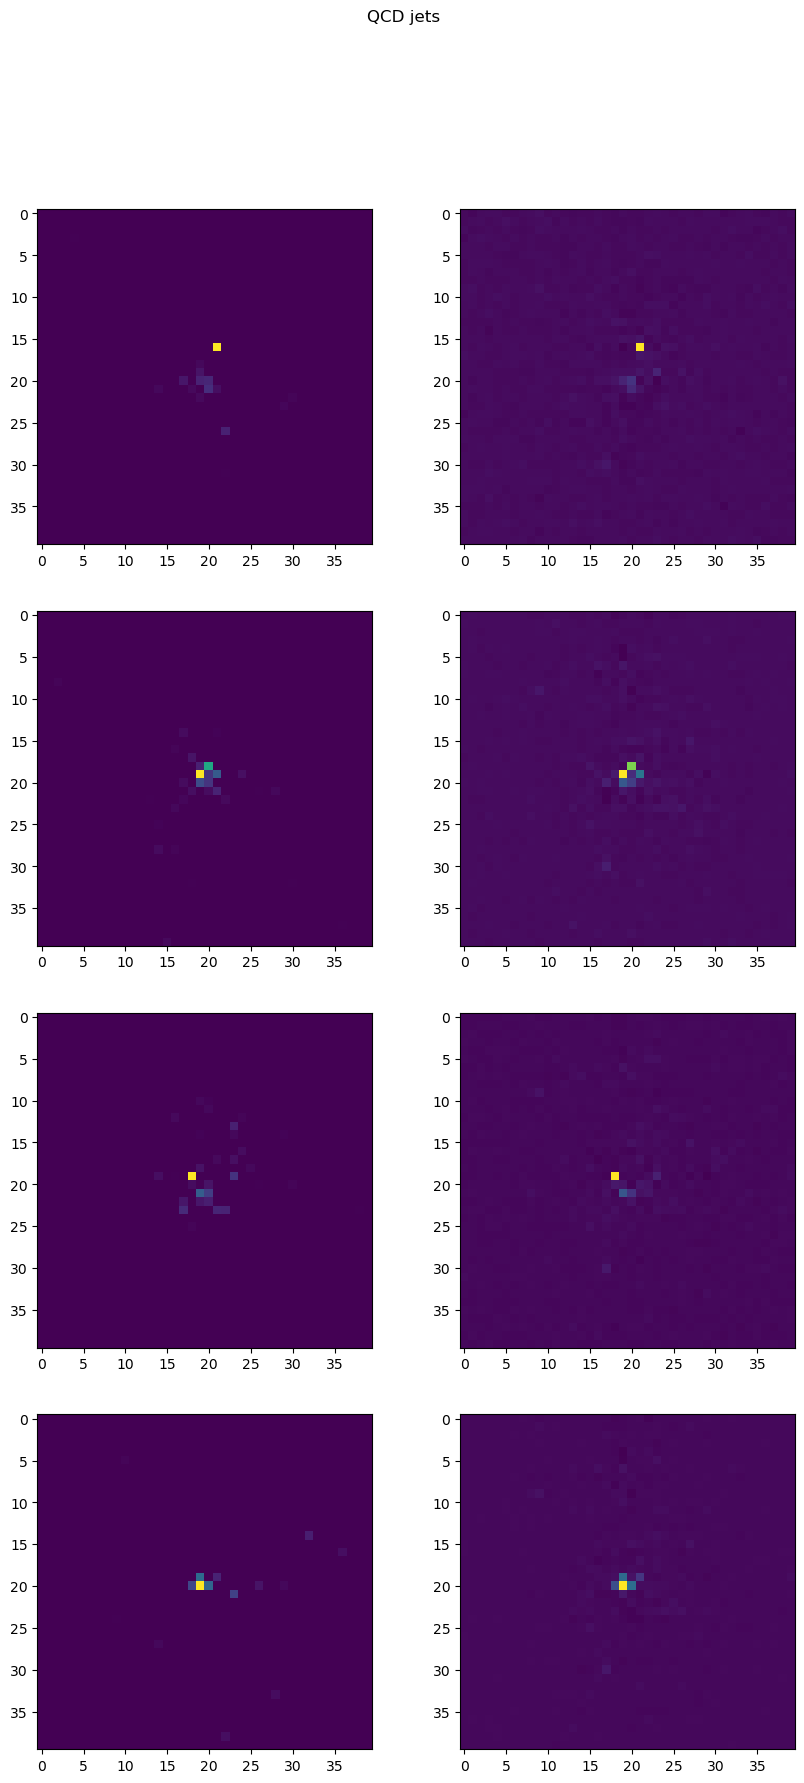

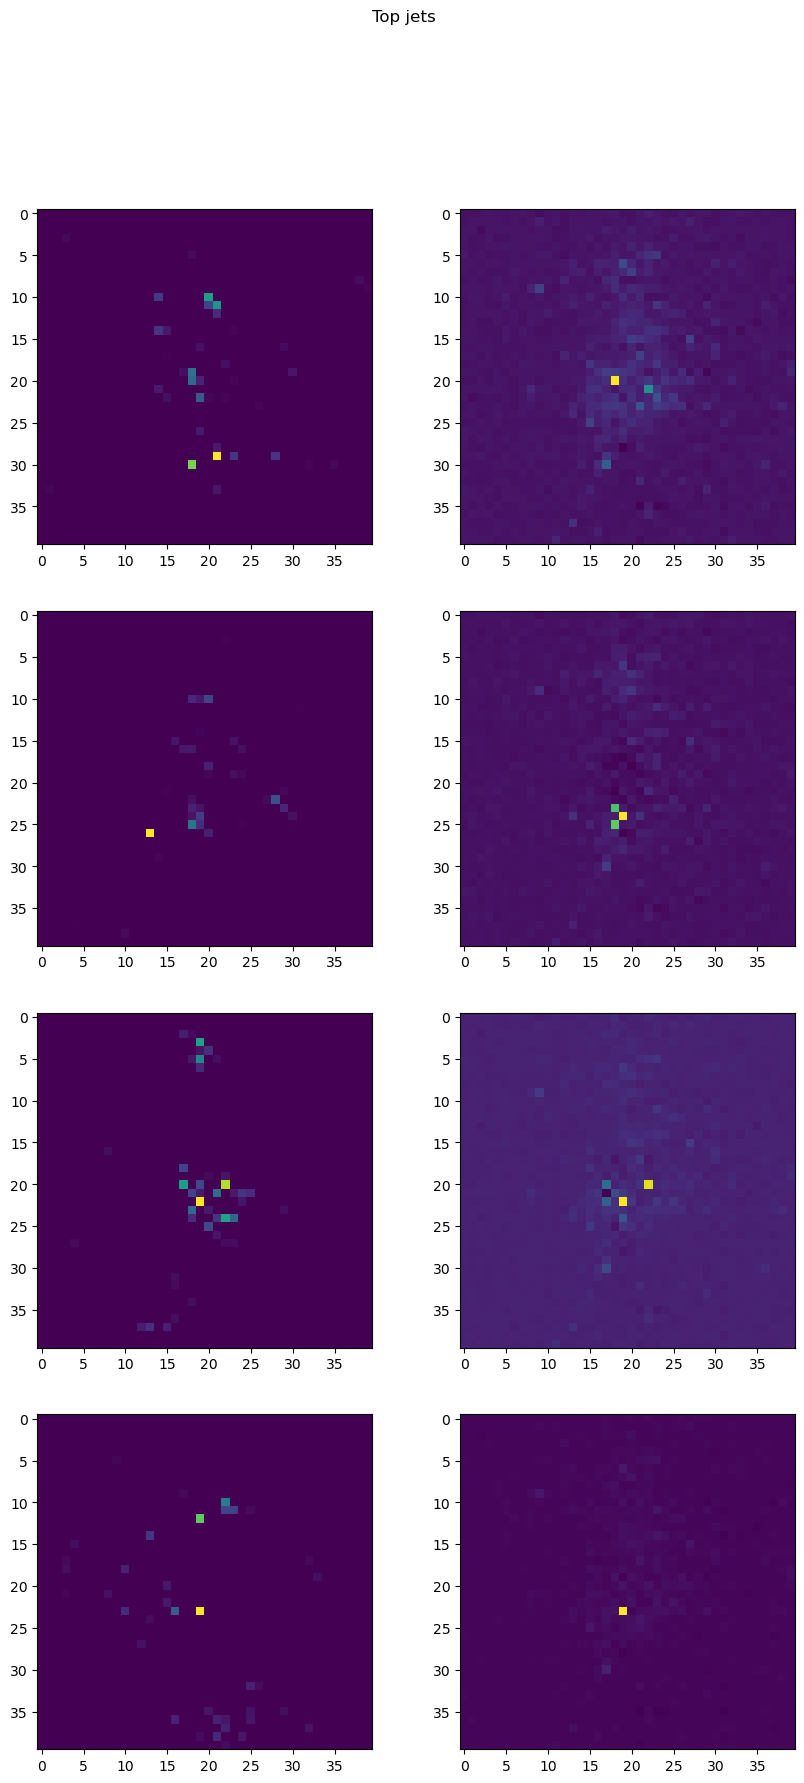

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axs[i, 0].imshow(plot_qcd[i][0].detach().numpy())
    axs[i, 1].imshow(qcd_model[i][0])
plt.suptitle("QCD jets")
plt.show()

fig, axs = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axs[i, 0].imshow(plot_top[i][0].detach().numpy())
    axs[i, 1].imshow(top_model[i][0])
plt.suptitle("Top jets")
plt.show()

It seems difficult to classifiy the output of the autoencoder to either the top jets or the qcd jets, by looking at the images. <br>
The autoencoder often seems to be able to reconstruct the main point of the image, but isn't well on the details. <br>

(d)

In [11]:
# TODO: Visualize pixel-wise MSE, plot ROC

def pic_mse(data, model):
    model.eval()
    out = model(data[0])

    mse = (data - out.detach().numpy())**2 /(len(data.flatten()))
    return mse

In [12]:
qcd_mse = np.zeros(plot_qcd.shape)
top_mse = np.zeros(plot_top.shape)

for i in range(4):
    qcd_mse[i] = pic_mse(plot_qcd[i], model)
    top_mse[i] = pic_mse(plot_top[i], model)

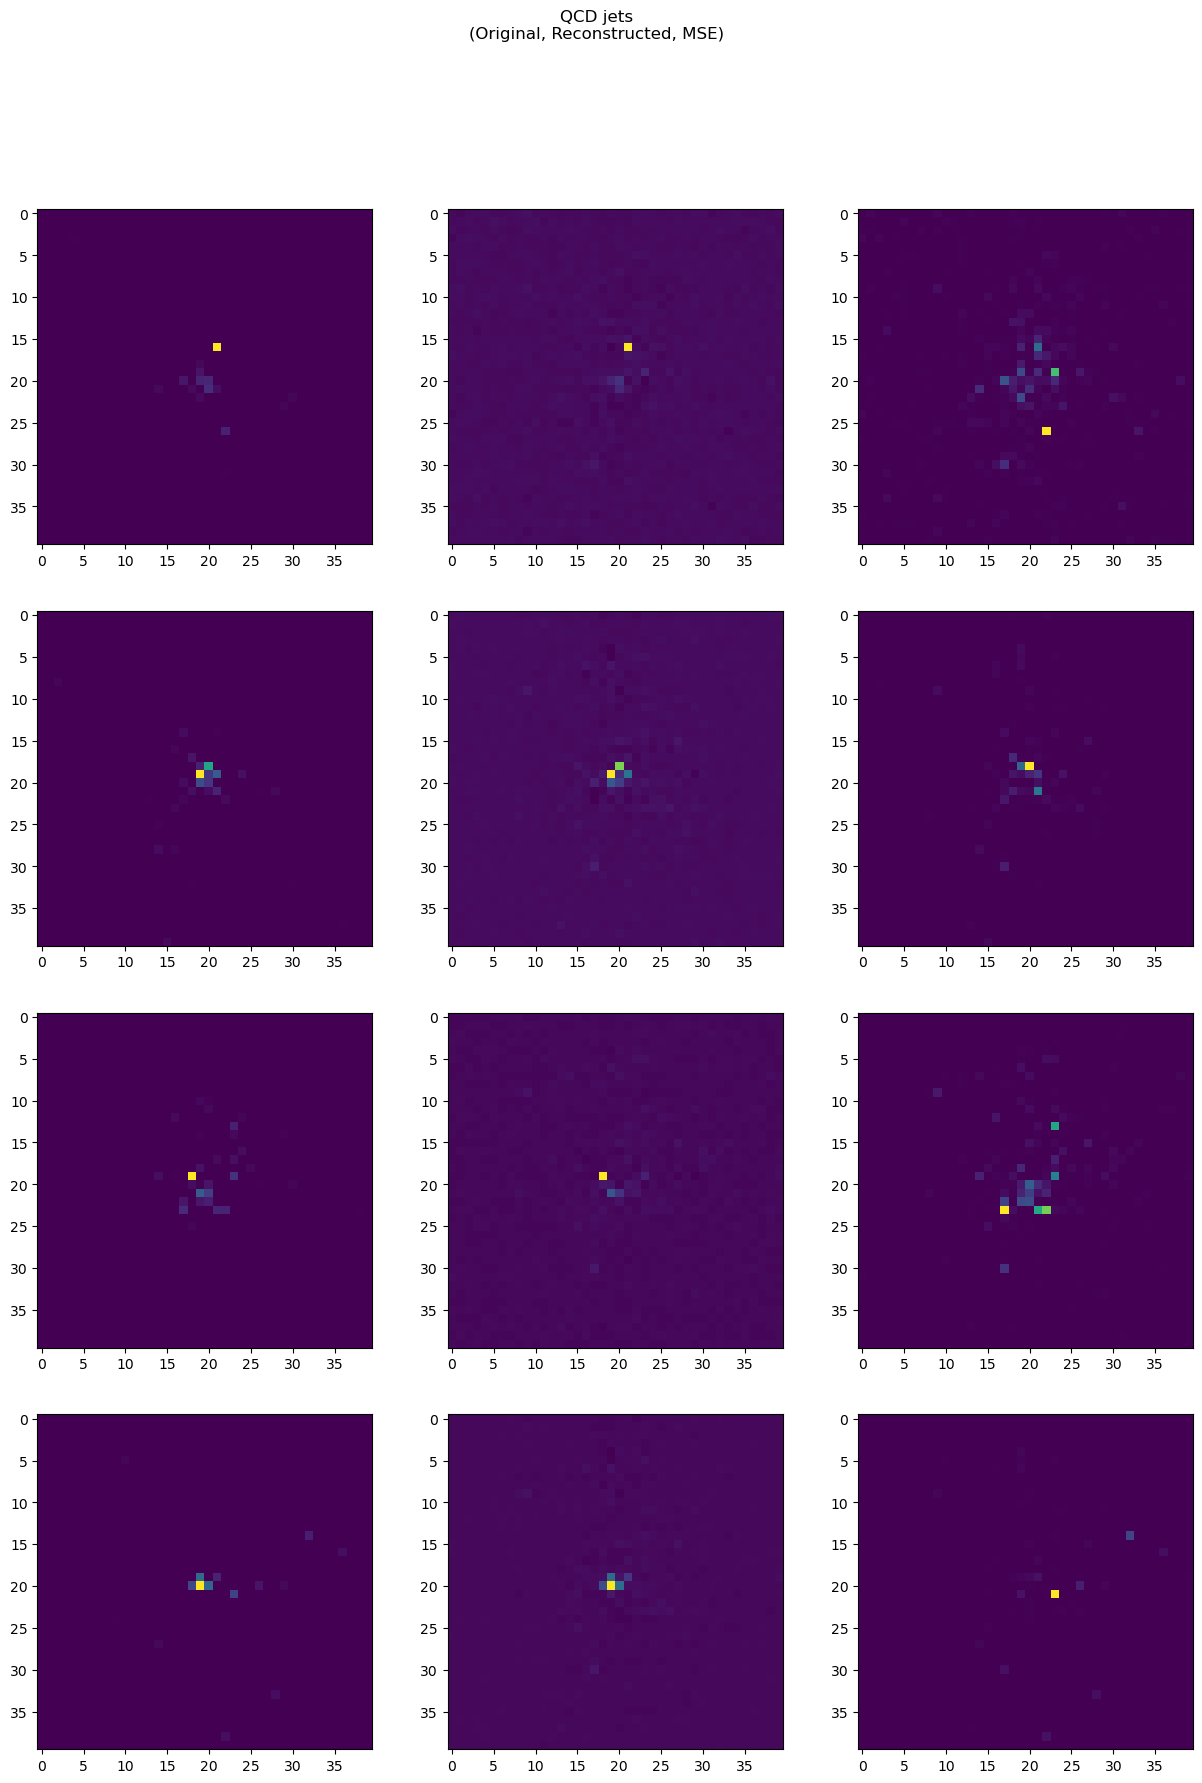

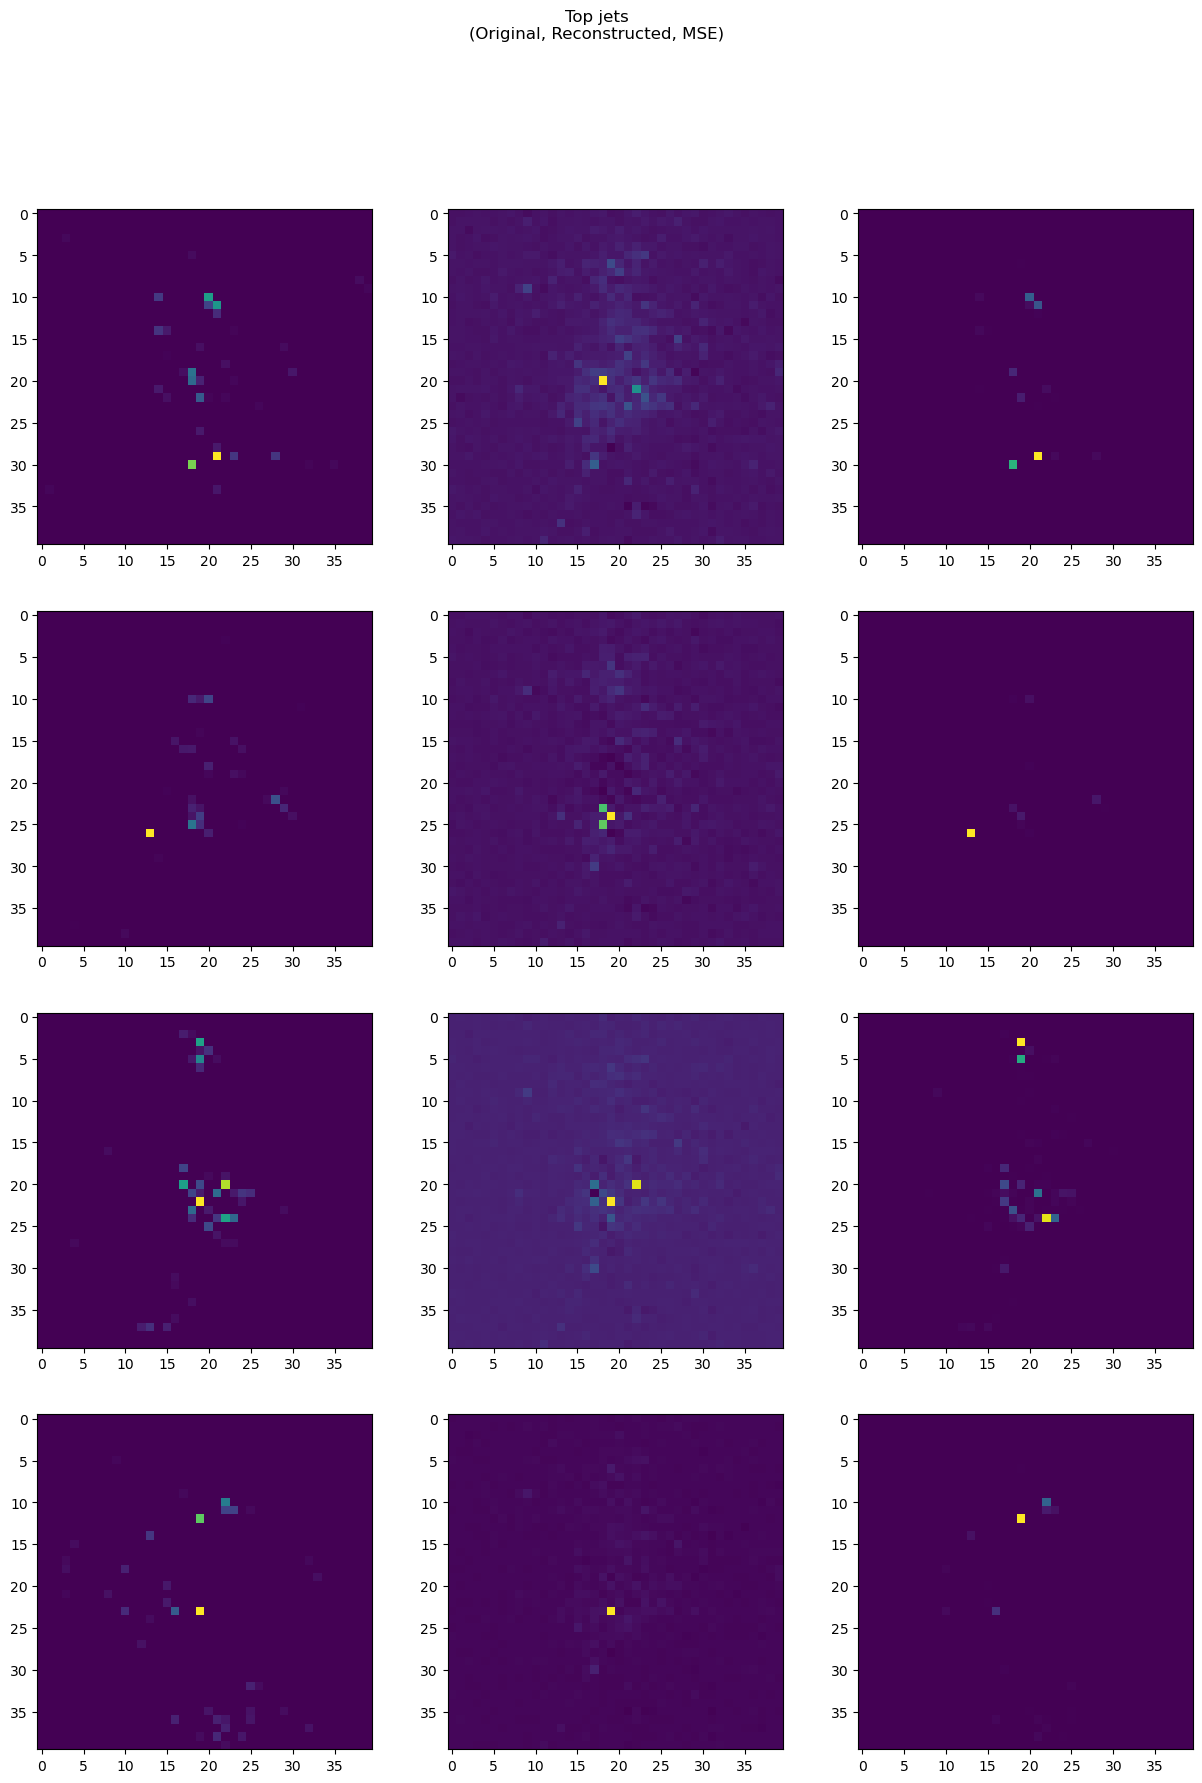

In [13]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

for i in range(4):
    axs[i, 0].imshow(plot_qcd[i][0].detach().numpy())
    axs[i, 1].imshow(qcd_model[i][0])
    axs[i, 2].imshow(qcd_mse[i][0])
plt.suptitle("QCD jets\n(Original, Reconstructed, MSE)")
plt.show()


fig, axs = plt.subplots(4, 3, figsize=(15, 20))
for i in range(4):
    axs[i, 0].imshow(plot_top[i][0].detach().numpy())
    axs[i, 1].imshow(top_model[i][0])
    axs[i, 2].imshow(top_mse[i][0])
plt.suptitle("Top jets\n(Original, Reconstructed, MSE)")
plt.show()

(e)

In [14]:
# TODO: Repeat everything for CNN

(f)

In [15]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN